In [2]:
import torchvision
from research_task_utils import *
import importlib
from torchsummary import summary
import numpy as np
# importlib.reload(research_task_utils)

In [17]:
batchsize = 512
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)
traindata = torchvision.datasets.CIFAR100(root="./dataset", train=True, download=True, transform=transform)
testdata = torchvision.datasets.CIFAR100(root="./dataset", train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
from collections import OrderedDict
class ConvBlock(torch.nn.Module):
    def __init__(self, num_of_convs, c_in, c_out, wh):
        super().__init__()
        
        self.num_of_convs = num_of_convs
        self.c_in = c_in
        self.c_out = c_out
        self.wh = wh
        
        layers = []
        
        assert num_of_convs > 0
        layers.append(('conv1',torch.nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1)))
        for k in range(1, num_of_convs):
            layers.append((f'relu_{k}',torch.nn.ReLU()))
            layers.append((f'conv_{k+1}',torch.nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1)))
            
        layers.append(('bn',torch.nn.BatchNorm2d(c_out)))
        layers.append((f'relu_{num_of_convs}',torch.nn.ReLU()))
        
        self.layers = torch.nn.Sequential(OrderedDict(layers))
        
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)
        
    def forward(self, x):
        return self.layers(x)
    
def num_of_convBlock_params(num_of_convs, c_in, c_out, wh):
    num = c_in*c_out*9 + c_out # first conv layer
    num += (num_of_convs - 1)*(c_out*c_out*9 + c_out) # other conv layers
    num += 2*c_out # BN params
    return num

In [19]:
class architecture2():
    def __init__(self, c1, c2, c3, c4, k1, k2, k3, k4):
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.c4 = c4
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        
        self.num_of_params = (num_of_convBlock_params(num_of_convs=k1, c_in=3, c_out=c1, wh=32) +
                              num_of_convBlock_params(num_of_convs=k2, c_in=c1, c_out=c2, wh=16) +
                              num_of_convBlock_params(num_of_convs=k3, c_in=c2, c_out=c3, wh=8) +
                              num_of_convBlock_params(num_of_convs=k4, c_in=c3, c_out=c4, wh=4) +
                              c4*100+100)
        
    def get_num_of_params(self):
        return self.num_of_params

In [29]:
initial_hyperparams = () #c1, c2, c3, c4, k1, k2, k3, k4
architecture2(8, 8, 16, 32, 4, 4, 4, 4).get_num_of_params()

48252

In [30]:
class ConvArchitecture2(torch.nn.Module):
    def __init__(self, model_hyperparams):
        super().__init__()
        
        c1, c2, c3, c4, k1, k2, k3, k4 = model_hyperparams
        self.hyperparams = model_hyperparams
        
        self.layers = torch.nn.Sequential(
            ConvBlock(num_of_convs=k1, c_in=3, c_out=c1, wh=32),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k2, c_in=c1, c_out=c2, wh=16),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k3, c_in=c2, c_out=c3, wh=8),
            torch.nn.MaxPool2d(kernel_size=2),
            
            ConvBlock(num_of_convs=k4, c_in=c3, c_out=c4, wh=4),
            
            torch.nn.AvgPool2d(kernel_size=4),
            torch.nn.Flatten(),
            torch.nn.Linear(c4, 100),
            torch.nn.Softmax(dim=-1)
        )
    
    def num_of_params(self, only_trainable: bool = False):
        parameters = list(self.parameters())
        if only_trainable:
            parameters = [p for p in parameters if p.requires_grad]
        unique = {p.data_ptr(): p for p in parameters}.values()
        return sum(p.numel() for p in unique)

    def forward(self, x):
        return self.layers(x)

In [44]:
import statistics
import json
import os

def add_statistics_to_json(model_info, statistics_dict, path):
    if not os.path.exists(path):
        with open(path, 'w') as f:
            json.dump([{"model_info": model_info, "statistics": statistics_dict}], f)
    else:
        with open(path) as f:
            old_data = json.load(f)
        with open(path, 'w') as f:
            json.dump(old_data+[{"model_info": model_info, "statistics": statistics_dict}], f)
    

def perform_experiment(device, trainloader, testloader, Model_class, model_hyperparams, epochs_n, repeats_n, path):
    train_accs = []
    test_accs = []
    
    for k in range(repeats_n):
        model = Model_class(model_hyperparams).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_function = torch.nn.CrossEntropyLoss()
        statistics_list = init_statistics(model, device, trainloader, testloader, loss_function)
        train(model, device, optimizer, loss_function, trainloader, testloader, statistics_list, epochs_n=epochs_n)
        train_accs.append(statistics_list["trainacc"][-1])
        test_accs.append(statistics_list["testacc"][-1])
        
        print("=================")
        print("Architecture: ", model_hyperparams)
        print("test acc:", statistics_list['testacc'][-1])
        plot_statistics(statistics_list)
        add_statistics_to_json(model_info={"name": "architecture2", "configuration": model_hyperparams,
                                           "comment": "third gridsearch with grads, 100 epochs, start from bad, laptop"},
                               statistics_dict=statistics_list,path=path)
        print("=================")
        
    if repeats_n != 1:
        test_accs_std = statistics.stdev(test_accs)
        train_accs_std = statistics.stdev(train_accs)
    else:
        test_accs_std, train_accs_std = 0, 0
        
    result = {"train_acc_mean": statistics.mean(train_accs),
              "train_acc_std": train_accs_std,
              "test_acc_mean": statistics.mean(test_accs),
              "test_acc_std": test_accs_std,
              "num_of_params": model.num_of_params()
             }
    if repeats_n == 1:
        result["statistics"] = statistics_list
    return result


def perform_experiments(device, trainloader, testloader, Model_class, hyperparams_list, epochs_n, repeats_n, path):
    results = dict()
    for hyperparam in hyperparams_list:
        results[hyperparam] = perform_experiment(device, trainloader, testloader,
                                                   Model_class, hyperparam, epochs_n, repeats_n, path)
    return results

    
def get_N(hyperparams, data_to_compute_gradients):
    return data_to_compute_gradients[hyperparams][0]

def get_acc(hyperparams, data_to_compute_gradients):
    return data_to_compute_gradients[hyperparams][1]

def get_grad_N(hyperparams, data_to_compute_gradients):
    grad = []
    for i in range(len(hyperparams)):
        hyperparams_tmp = list(hyperparams)
        hyperparams_tmp[i] += 1
        grad.append(get_N(tuple(hyperparams_tmp), data_to_compute_gradients) 
                    - get_N(hyperparams, data_to_compute_gradients))
    return np.array(grad)

def get_grad_acc(hyperparams, data_to_compute_gradients):
    grad = []
    for i in range(len(hyperparams)):
        hyperparams_tmp = list(hyperparams)
        hyperparams_tmp[i] += 1
        grad.append(get_acc(tuple(hyperparams_tmp), data_to_compute_gradients) 
                    - get_acc(hyperparams, data_to_compute_gradients))
    return np.array(grad)

def generate_architectures_to_check(initial_hyperparams):
    architectures = [initial_hyperparams]
    for i in range(len(initial_hyperparams)):
        hyperparams_tmp = list(initial_hyperparams)
        hyperparams_tmp[i] += 1
        architectures.append(tuple(hyperparams_tmp))
    return architectures

In [45]:
# # замерджить файлы с колаба и с пк

# with open("models_logs_gradsearch.json") as f:
#     data_pc = json.load(f)
# with open("models_logs_gradsearch_colab.json") as f:
#     data_colab = json.load(f)
# with open("models_logs_gradsearch_merged.json", 'w') as f:
#     json.dump(data_pc + list(reversed(data_colab)), f)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [28:04<00:00, 16.85s/it]

Architecture:  (8, 8, 16, 32, 4, 4, 4, 4)
test acc: 0.2168


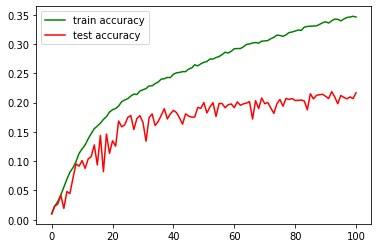

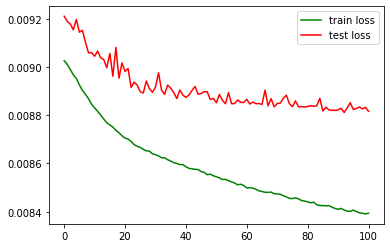

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [29:22<00:00, 17.62s/it]

Architecture:  (9, 8, 16, 32, 4, 4, 4, 4)
test acc: 0.2116


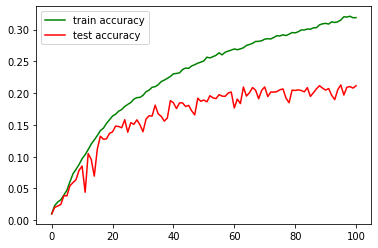

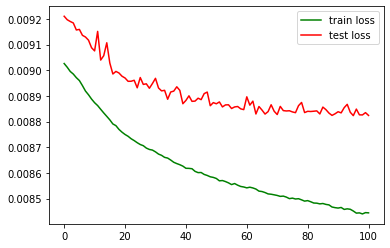

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [28:33<00:00, 17.14s/it]

Architecture:  (8, 9, 16, 32, 4, 4, 4, 4)
test acc: 0.2017


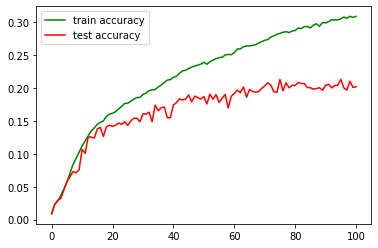

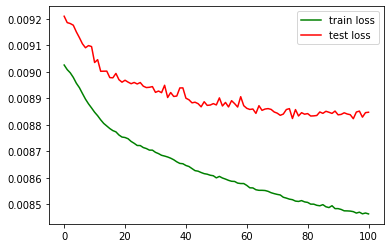

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [28:12<00:00, 16.93s/it]

Architecture:  (8, 8, 17, 32, 4, 4, 4, 4)
test acc: 0.1968


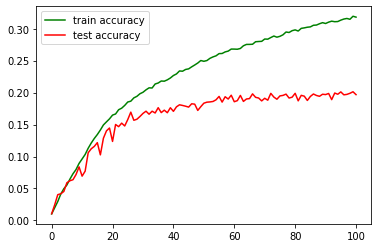

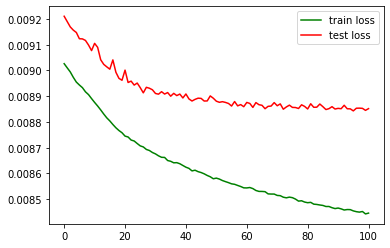

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [28:40<00:00, 17.20s/it]

Architecture:  (8, 8, 16, 33, 4, 4, 4, 4)
test acc: 0.2132


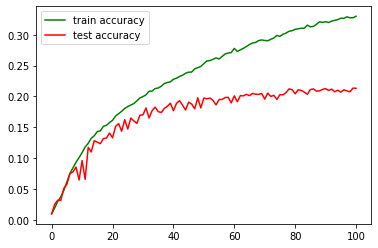

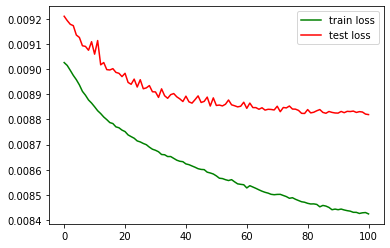

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [30:41<00:00, 18.41s/it]

Architecture:  (8, 8, 16, 32, 5, 4, 4, 4)
test acc: 0.1888


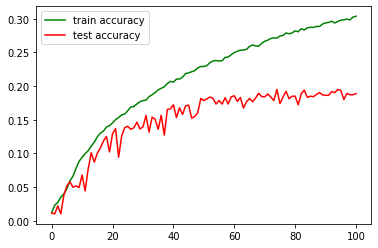

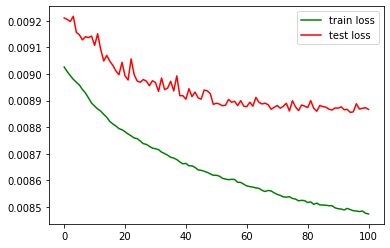

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [29:23<00:00, 17.63s/it]

Architecture:  (8, 8, 16, 32, 4, 5, 4, 4)
test acc: 0.2042


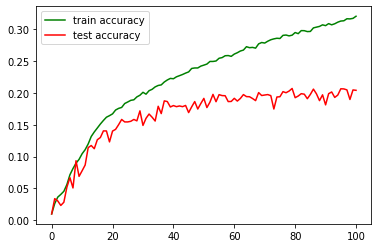

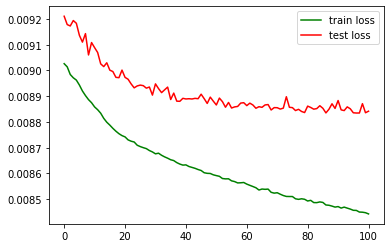

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [28:29<00:00, 17.09s/it]

Architecture:  (8, 8, 16, 32, 4, 4, 5, 4)
test acc: 0.2146


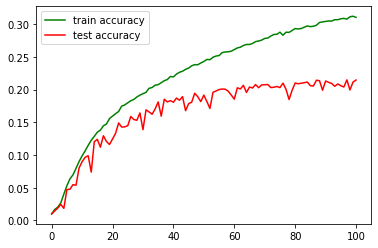

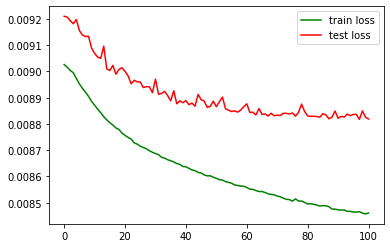

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [28:51<00:00, 17.32s/it]

Architecture:  (8, 8, 16, 32, 4, 4, 4, 5)
test acc: 0.1902


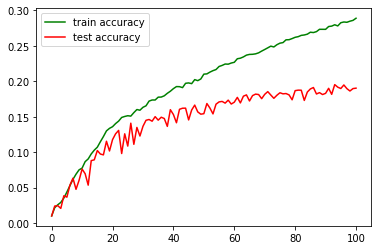

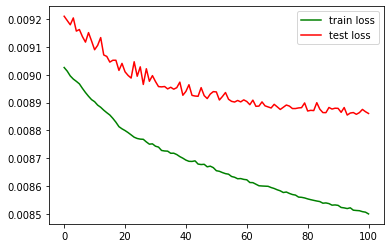

NEW INITIAL PARAMS:  (7, 7, 14, 33, 1, 2, 5, 4)


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:15<00:00, 10.96s/it]

Architecture:  (7, 7, 14, 33, 1, 2, 5, 4)
test acc: 0.1928


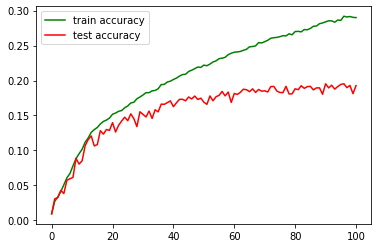

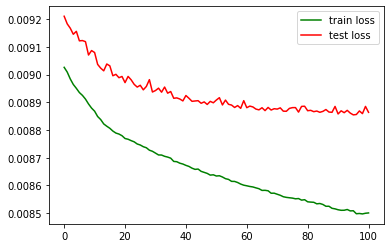

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:21<00:00, 11.02s/it]

Architecture:  (8, 7, 14, 33, 1, 2, 5, 4)
test acc: 0.1895


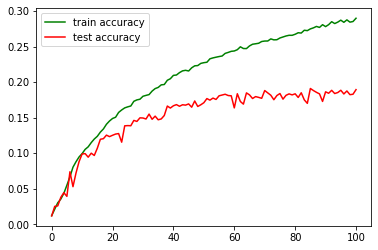

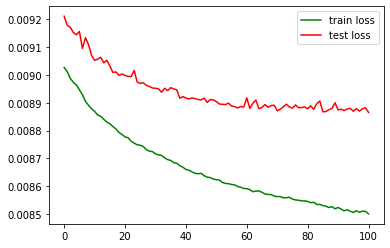

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:17<00:00, 10.98s/it]

Architecture:  (7, 8, 14, 33, 1, 2, 5, 4)
test acc: 0.2029


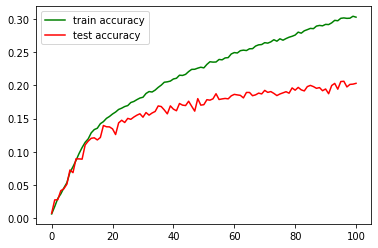

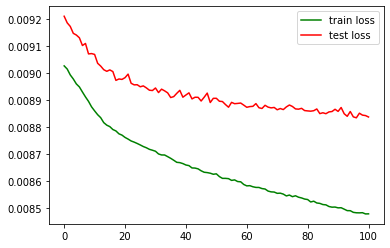

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:21<00:00, 11.01s/it]

Architecture:  (7, 7, 15, 33, 1, 2, 5, 4)
test acc: 0.2011


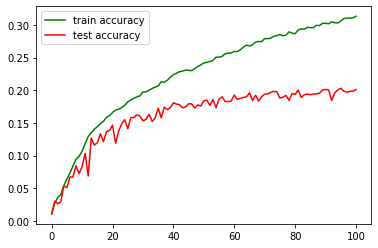

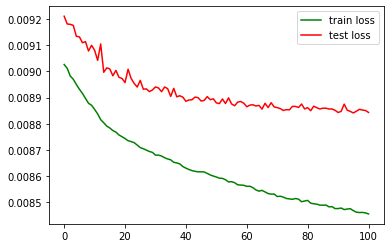

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:15<00:00, 10.95s/it]

Architecture:  (7, 7, 14, 34, 1, 2, 5, 4)
test acc: 0.1911


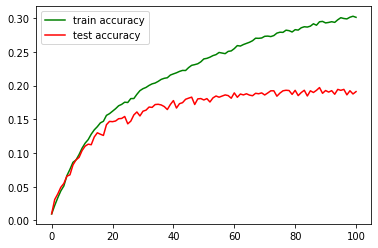

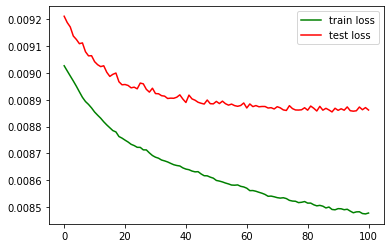

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [20:39<00:00, 12.39s/it]

Architecture:  (7, 7, 14, 33, 2, 2, 5, 4)
test acc: 0.212


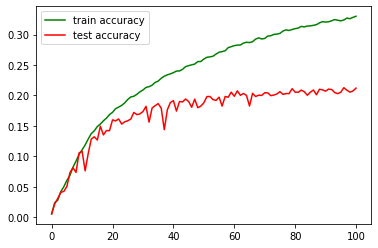

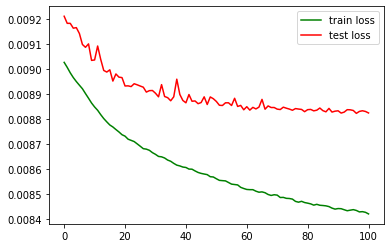

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [19:35<00:00, 11.76s/it]

Architecture:  (7, 7, 14, 33, 1, 3, 5, 4)
test acc: 0.1872


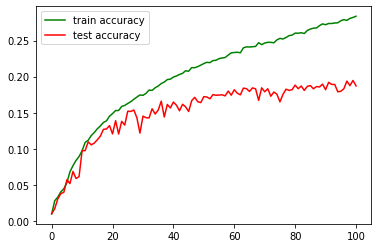

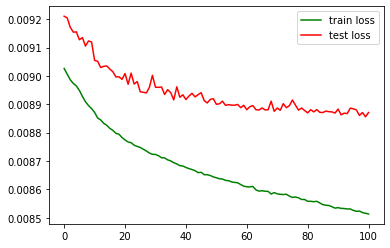

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:32<00:00, 11.12s/it]

Architecture:  (7, 7, 14, 33, 1, 2, 6, 4)
test acc: 0.1826


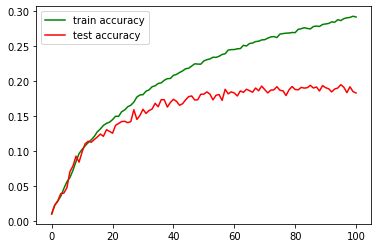

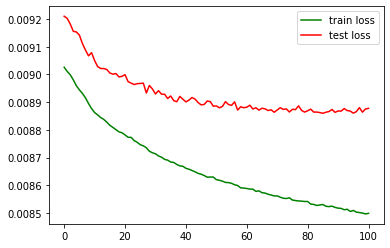

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [18:39<00:00, 11.20s/it]

Architecture:  (7, 7, 14, 33, 1, 2, 5, 5)
test acc: 0.1769


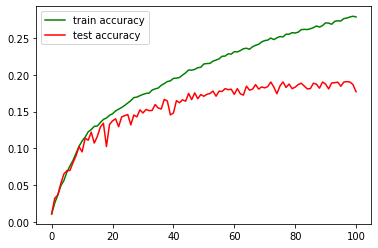

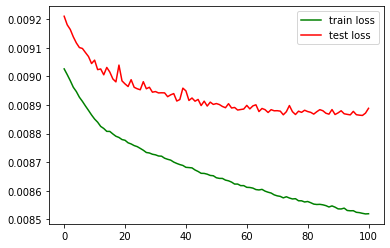

NEW INITIAL PARAMS:  (6, 9, 16, 33, 5, 1, 4, 4)


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:33<00:00, 15.33s/it]


Architecture:  (6, 9, 16, 33, 5, 1, 4, 4)
test acc: 0.2083


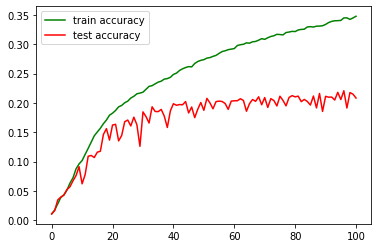

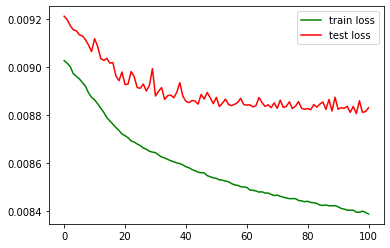

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [26:34<00:00, 15.95s/it]


Architecture:  (7, 9, 16, 33, 5, 1, 4, 4)
test acc: 0.2178


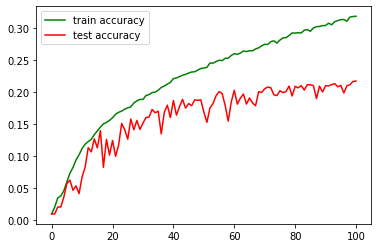

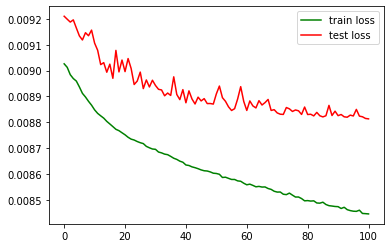

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:48<00:00, 15.49s/it]

Architecture:  (6, 10, 16, 33, 5, 1, 4, 4)
test acc: 0.0934


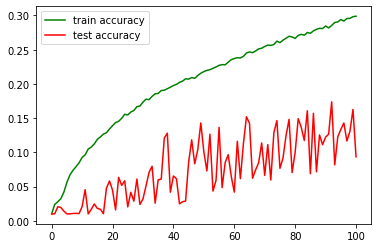

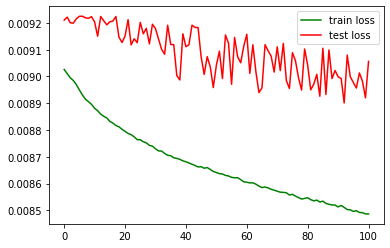

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:55<00:00, 15.55s/it]

Architecture:  (6, 9, 17, 33, 5, 1, 4, 4)
test acc: 0.2045


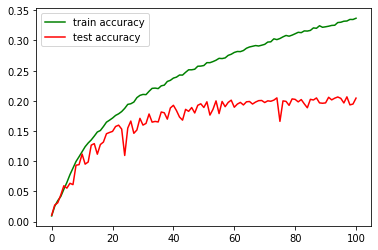

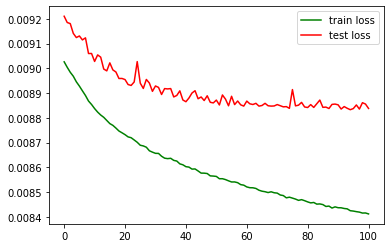

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:43<00:00, 15.44s/it]

Architecture:  (6, 9, 16, 34, 5, 1, 4, 4)
test acc: 0.229


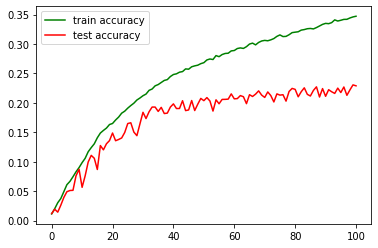

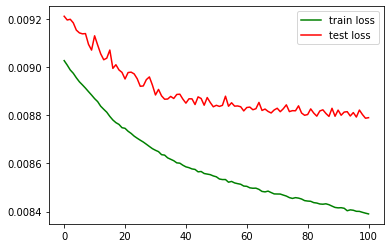

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [27:09<00:00, 16.29s/it]

Architecture:  (6, 9, 16, 33, 6, 1, 4, 4)
test acc: 0.1873


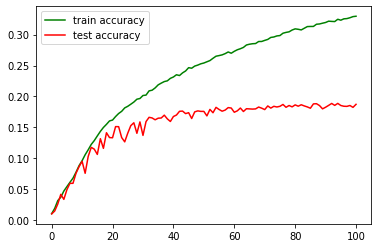

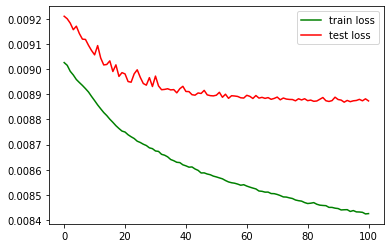

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [26:20<00:00, 15.80s/it]

Architecture:  (6, 9, 16, 33, 5, 2, 4, 4)
test acc: 0.198


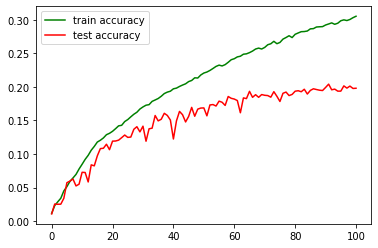

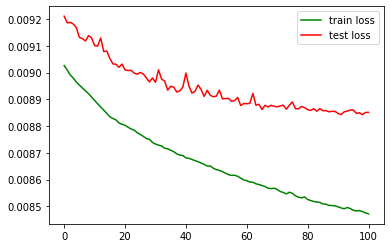

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:17<00:00, 15.18s/it]

Architecture:  (6, 9, 16, 33, 5, 1, 5, 4)
test acc: 0.1927


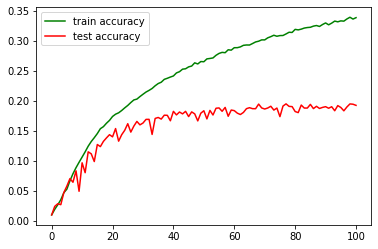

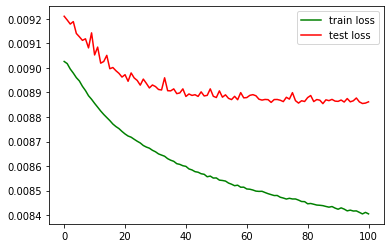

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:44<00:00, 15.44s/it]

Architecture:  (6, 9, 16, 33, 5, 1, 4, 5)
test acc: 0.1797


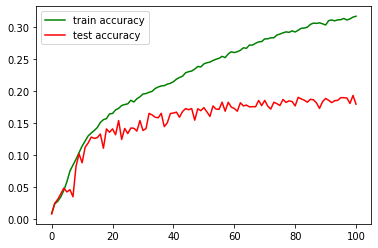

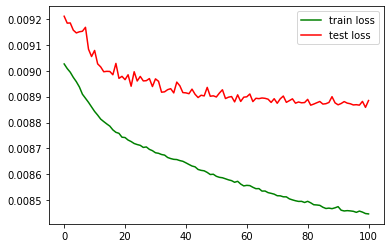

NEW INITIAL PARAMS:  (6, 4, 16, 34, 4, 1, 3, 4)


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [24:27<00:00, 14.67s/it]


Architecture:  (6, 4, 16, 34, 4, 1, 3, 4)
test acc: 0.177


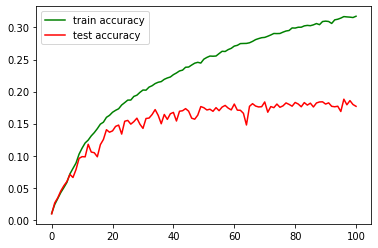

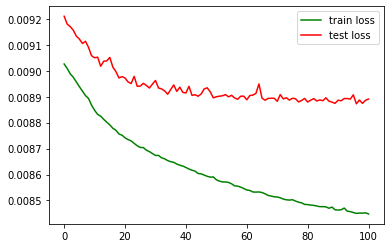

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [25:06<00:00, 15.07s/it]


Architecture:  (7, 4, 16, 34, 4, 1, 3, 4)
test acc: 0.2212


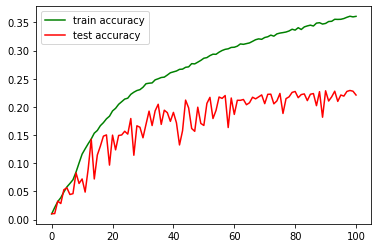

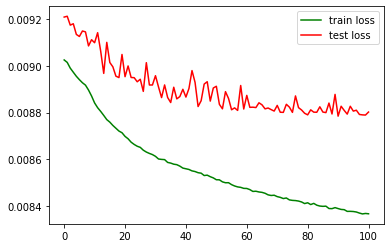

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [23:46<00:00, 14.26s/it]


Architecture:  (6, 5, 16, 34, 4, 1, 3, 4)
test acc: 0.2006


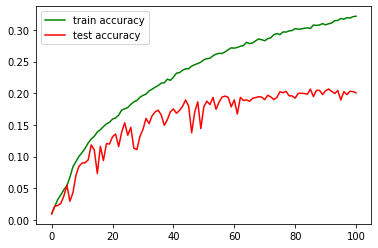

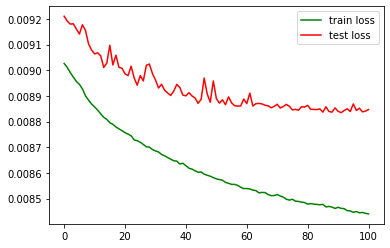

 29%|██████████████████████▌                                                       | 29/100 [07:34<18:31, 15.66s/it]


KeyboardInterrupt: 

In [49]:
initial_hyperparams = (8, 8, 16, 32, 4, 4, 4, 4) #c1, c2, c3, c4, k1, k2, k3, k4
# initial_hyperparams = (3, 6, 12, 24, 8, 8, 1, 1)
path = "models_logs_gradsearch3_laptop_15k_start_from_bad.json"

= 5
while (True):
    architectures = generate_architectures_to_check(initial_hyperparams)
    results = perform_experiments(device, trainloader, testloader,
                                  ConvArchitecture2, architectures, epochs_n=100, repeats_n=1, path=path)
    
    
    with open(path) as f:
        logs = json.load(f)
        
    data_to_compute_gradients = {}
    for log in logs:
        configuration = log["model_info"]["configuration"]
        c1, c2, c3, c4, k1, k2, k3, k4 = tuple(configuration)
        num_of_params = architecture2(c1, c2, c3, c4, k1, k2, k3, k4).get_num_of_params()
        acc_avg = statistics.mean(log["statistics"]["testacc"][-10:])
        data_to_compute_gradients[tuple(configuration)] =  (num_of_params, acc_avg)
        
    grad_N = get_grad_N(initial_hyperparams, data_to_compute_gradients)
    grad_acc = get_grad_acc(initial_hyperparams, data_to_compute_gradients)

    direction_to_change_params = grad_acc - np.dot(grad_N, grad_acc) / np.dot(grad_N, grad_N) * grad_N
    direction_to_change_params /= np.linalg.norm(direction_to_change_params)
        
    new_hyperparams = np.array(initial_hyperparams) + K*direction_to_change_params
    new_hyperparams = np.rint(new_hyperparams).astype(int)
    
    initial_hyperparams = [] # json не дружит с np.int64
    for i in range(8):
        if new_hyperparams[i] < 1:
            new_hyperparams[i] = 1
        initial_hyperparams.append(int(new_hyperparams[i]))
    initial_hyperparams = tuple(initial_hyperparams)
    print("NEW INITIAL PARAMS: ", initial_hyperparams)